<h1>Deep Learning 101</h1>
<h2>From zero to your first Convolutional Neural Net</h2>
<p>What are we doing? Training a simple *conv net* on the *MNIST dataset*.
Gets to 99.25% test accuracy pretty quickly. Caveat: a DL level 1 approach would be to just run the code and see what happens, maybe change some values or change the data coming in to something different. A DL level 2 approach would be to read all the extra references to understand just what's happening under the hood.</p>

<h3>"Conv Net?" I hear you ask...</h3>

<span>Stands for convolutional neural net, which usually takes some image as input, performs a bunch of convolutions to learn which features in the image are important for classifying what it is and then depending on the architecture, can make a prediction of the class. Generally speaking a class can be the category that image belongs to or a digit representation of what the image label is, e.g. two classes, one for cats, one for dogs might the labels 0 and 1 for cats and dogs respectively. More on what 'convolutions' are and how to implement them <a href="https://elitedatascience.com/keras-tutorial-deep-learning-in-python" target="_blank">here</a>, <a href="http://course.fast.ai/lessons/lesson3.html">here (FastAI)</a>, and <a href="https://www.tensorflow.org/versions/r1.0/tutorials/layers">here (Tensorflow)</a>.</span>
<img src="https://34tzkp3af7ck1k675g1stf6n-wpengine.netdna-ssl.com/wp-content/uploads/2016/11/typical_cnn_architecture.png"/>

<h3>"MNIST?? What's with the acronyms?"</h3>
<span>This is the Helloworld dataset of machine learning and deep learning. It is a useful dataset for quickly testing that an architecture runs end to end and can be used for prototyping but it isn't a perfect dataset for more complex tasks and shouldn't be used to verify a completely new algorithm in DL, at least not in isolation!</span>

<img src="https://34tzkp3af7ck1k675g1stf6n-wpengine.netdna-ssl.com/wp-content/uploads/2016/11/mnist.png"/>
<img src="https://www.tensorflow.org/versions/r1.0/images/mnist_0-9.png">


<span>This is what it looks like! A series of 50000 or so hand-written digits from 0 to 9, in very tiny format - 28x28 binary (so no three channel RGB)</span>


In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

/home/becks/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/becks/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<h2>Some definitions</h2>
<h4>Batch Size</h4>

<span>Basically, to avoid having to pass your entire dataset through the model every time (which is sometimes impossible due to memory constraints!), the batch size allows you to define how many data points from the overall dataset go through at each training step.</span>

<h4>Epochs</h4>

<span>The number of times the entire dataset gets passed forward and backward through the model. Passing through only once often leads to underfitting, but passing it through too many times causes overfitting! You can often use stopping criteria (google that!) in order to stop the training cycle once optimum performance is achieved, before overfitting occurs. Also note that if you've split your dataset into batches, then several iterations will occur per epoch (e.g. 200 data points in batchs of 50 will take 4 iterations per epoch). Thanks to <a href="https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9">Sagar from Towards Data Science</a> for this great pic:</span>

<img src="https://cdn-images-1.medium.com/max/1600/1*i_lp_hUFyUD_Sq4pLer28g.png">

<h4>Classes</h4>

<span>As mentioned in the Conv Net section, the number of classes defines how many things you are trying to classify, e.g. dogs, cats, birds for classes 0, 1, 2 or in our case, digits from 0 to 9 which will give us 10 different classes.</span>


In [4]:
# input image dimensions, as mentioned above, mnist digits come in 28x28 size
img_rows, img_cols = 28, 28

# load the data and split between train and test sets, where x refers to the input data and y is the class labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# perform a bit of data reshaping since Keras backend expects the images to pass through 
# in the format (channels, rows, columns), but Tensorflow and others expect (rows, columns, channels)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# Keras likes to know how big things are when making 'Input' type layers
input_shape = (img_rows, img_cols, 1)


# convert class vectors to binary class matrices ## EXPLAIN MORE ##
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

<h2>Training and Testing? What's the difference?</h2>

<span>In order to 'learn', i.e. figure out the best parameters to predict target classes from the data, the model is trained on a sub-set of the total data. Then to make sure that it has learned useful things, it can be tested on the remaining data without ever having been exposed to it as part of the training. This is important for checking how generalised your model is and how well it will deal with data in the wild.</span>

<span>What is involved in this so-called "learning" stage? I'm glad you asked... Mostly Gradient Descent and variations thereof, which is covered in way more exciting detail <a href="https://medium.com/machine-learning-for-humans/supervised-learning-740383a2feab">here</a> and <a href="https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/">here</a>.</span>

In [5]:
# Now for the model architecture!

# This line just initialises a Keras sequential model
model = Sequential()

# This is a fairly standard format for a shallow conv net on simple data (MNIST)
# We'll go through some of the layers in very high level detail with some resources to learn more
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


<h2>Wow, my first DL model! But what does it all mean??</h2>

<span>First things first - deep learning models are like cake or onions or orges, if you're a Shrek fan, they all have layers. And there are some nice standards for conv nets that classify 'simple' data from images. </span>

<img src="thingswithlayers.png" caption="These are some things with layers">

Each layer is essentially a big matrix of values that are 'connected together' to get some output. This means that they have a certain shape and size in addition to performing certain functions. Here's a run down of what each of them is doing:

<strong>Convolutional Layer</strong>

<span>You pick a kernel (i.e. some small matrix, usually 3x3) and move it over the image (convole it) to produce new values in a size determined by the number of filters and the image input size. You can have many convolutional layers in a row. <a href="https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/">Here</a> is a pretty good guide too. Oh, and <a href="https://deeplearning4j.org/convolutionalnetwork">here!</a></span>

<img src="https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196">

<strong>Max Pooling Layer</strong>

<span>This is the layer that shrinks the size of your previous outputs just like a tiered cake getting smaller the higher up it goes. It looks at some square (of a size you choose, e.g. 2x2) and picks the highest number to pass on then moves across/down by some distance (the stride length, in our case 2) to cover the whole matrix. The principle is that only the strongest activations get to pass through.</span>

<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=494">

<strong>Dropout Layer</strong>
<span>This is a form of 'regularisation' which is a way of preventing the model from overfitting. In comes in many flavours, but in the case of dropout, you specify how much of the input to 'ignore' or not use in the backwards and forwards pass. Like a coach randomly deciding with some probability 'p' to allow players on the field or not. More on how and why this works <a href="https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5">here</a>.

<img src="https://cdn-images-1.medium.com/max/800/1*iWQzxhVlvadk6VAJjsgXgg.png">

<strong>Flatten Layer</strong>
<span>Does what it says on the box! Make the matrix go from multi-dimensional to squashed one dimensional.</span>

<strong>Dense Layer</strong>
<span>Also known as a 'Fully Connected Layer', or 'Multi-Layer Perceptron'. Allows non-linear combinations of features extracted by the conv and max pool layers and means that every node in the layer is connected to every other node.</span>

<strong>Activation Layers</strong>
<span>These include ReLU and Softmax. ReLU (Rectified Linear Unit) converts all negative numbers to zero. And Softmax squishes all values so that the sum is between 0 and 1</span>


In [6]:
# Assemble the cake, I mean, DL model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# "Learn all of the things"
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 171s 3ms/step - loss: 1.0639 - acc: 0.8276 - val_loss: 0.0850 - val_acc: 0.9752
Epoch 2/12
60000/60000 [==============================] - 173s 3ms/step - loss: 0.1595 - acc: 0.9544 - val_loss: 0.0528 - val_acc: 0.9836
Epoch 3/12
60000/60000 [==============================] - 177s 3ms/step - loss: 0.1036 - acc: 0.9698 - val_loss: 0.0460 - val_acc: 0.9874
Epoch 4/12
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0809 - acc: 0.9764 - val_loss: 0.0350 - val_acc: 0.9886
Epoch 5/12
60000/60000 [==============================] - 174s 3ms/step - loss: 0.0637 - acc: 0.9814 - val_loss: 0.0377 - val_acc: 0.9873
Epoch 6/12
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0563 - acc: 0.9835 - val_loss: 0.0316 - val_acc: 0.9888
Epoch 7/12
60000/60000 [==============================] - 172s 3ms/step - loss: 0.0500 - acc: 0.9856 - val_loss: 0.0300 - 

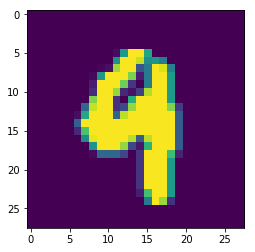

I think this number is a... 9


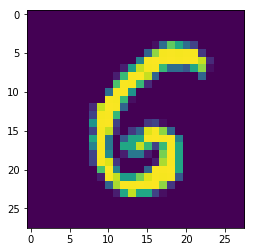

I think this number is a... 6


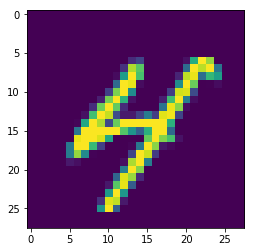

I think this number is a... 4


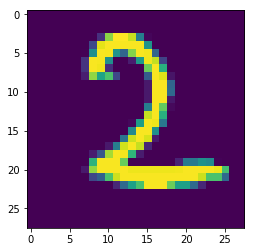

I think this number is a... 2


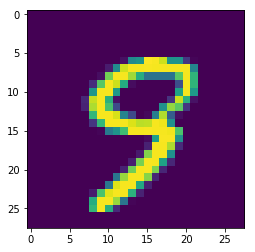

I think this number is a... 9


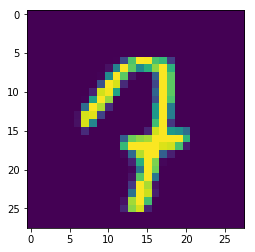

I think this number is a... 7


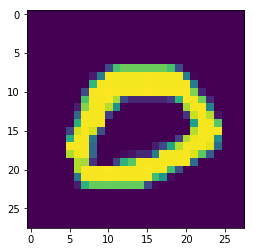

I think this number is a... 0


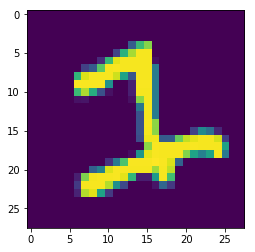

I think this number is a... 2


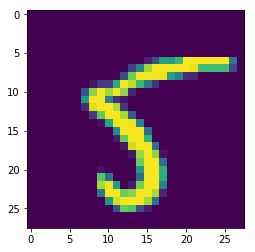

I think this number is a... 5


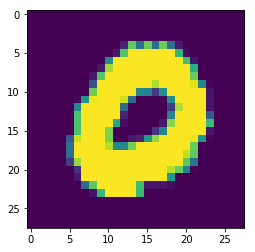

I think this number is a... 0


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def what_number_is_this(number_picture):
    # what's the argmax for? The model outputs a vector of 10 numbers that indicate how likely the input is to be
    # a digit belonging to 
    return np.argmax(model.predict(number_picture))

random_test_set = np.random.randint(0, 9999, 10)
for i in random_test_set:
    test_im = x_test[i,:,:,:]
    plt.imshow(np.reshape(test_im, [28,28]))
    plt.show()
    print("I think this number is a...", what_number_is_this(np.expand_dims(test_im, axis=0)))